## Product Sales Analytics

This analysis provides insights into the product categories.

In [1]:
# Required Libraries
import pandas as pd
import numpy as np
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import matplotlib.ticker as mticker
plt.style.use('ggplot') 

# Supress warnings
import warnings
warnings.filterwarnings('ignore')

# Display settings
pd.options.display.float_format = '{:.2f}'.format 
pd.options.display.max_columns=None
pd.options.display.max_rows=None
pd.set_option('display.max_colwidth', None)

In [2]:
# Read the dataset

data = pd.read_csv('../customer_shopping_data.csv')
data.head()

,invoice_no,customer_id,gender,age,category,quantity,price,payment_method,invoice_date,shopping_mall
0,I138884,C241288,Female,28,Clothing,5,1500.40,Credit Card,5/8/2022,Kanyon
1,I317333,C111565,Male,21,Shoes,3,1800.51,Debit Card,12/12/2021,Forum Istanbul
2,I127801,C266599,Male,20,Clothing,1,300.08,Cash,9/11/2021,Metrocity
3,I173702,C988172,Female,66,Shoes,5,3000.85,Credit Card,16/05/2021,Metropol AVM
4,I337046,C189076,Female,53,Books,4,60.60,Cash,24/10/2021,Kanyon


In [3]:
# convert invoice date to datetime format
data['invoice_date'] = pd.to_datetime(data['invoice_date'])

# create year and month columns from invoice date
data['invoice_year'] = data['invoice_date'].dt.year
data['invoice_month'] = data['invoice_date'].dt.strftime('%B')

# create total revenue column
data['total_revenue'] = data['quantity'] * data['price']
data.head()

,invoice_no,customer_id,gender,age,category,quantity,price,payment_method,invoice_date,shopping_mall,invoice_year,invoice_month,total_revenue
0,I138884,C241288,Female,28,Clothing,5,1500.40,Credit Card,2022-05-08,Kanyon,2022,May,7502.00
1,I317333,C111565,Male,21,Shoes,3,1800.51,Debit Card,2021-12-12,Forum Istanbul,2021,December,5401.53
2,I127801,C266599,Male,20,Clothing,1,300.08,Cash,2021-09-11,Metrocity,2021,September,300.08
3,I173702,C988172,Female,66,Shoes,5,3000.85,Credit Card,2021-05-16,Metropol AVM,2021,May,15004.25
4,I337046,C189076,Female,53,Books,4,60.60,Cash,2021-10-24,Kanyon,2021,October,242.40


In [4]:
# HELPER FUNCTIONS

def format_revenue_with_thousand_separator(x):
    """
        function to format the revenue values with thousand separators
    """
    return "${:,.2f}".format(x)

## Data Overview

In [5]:
# Proportion of each product category
product_category_data = pd.DataFrame(data['category'].value_counts().reset_index().values, 
                                     columns=['ProductCategory','TotalCount'])
product_category_data['PercentCount'] = product_category_data['TotalCount'] / len(data) * 100
product_category_data

,ProductCategory,TotalCount,PercentCount
0,Clothing,34487,34.68
1,Cosmetics,15097,15.18
2,Food & Beverage,14776,14.86
3,Toys,10087,10.14
4,Shoes,10034,10.09
5,Souvenir,4999,5.03
6,Technology,4996,5.02
7,Books,4981,5.01


## Product Sales Analysis

### 1. Which product category has the highest sales revenue?

In [6]:
# revenue by category
revenue_by_category = data.groupby('category')['total_revenue'].sum()

highest_revenue_category = revenue_by_category.idxmax()
highest_revenue = revenue_by_category.max()

print(f"The product category with the highest sales revenue is: \
{highest_revenue_category} - ${highest_revenue:,.2f}")

The product category with the highest sales revenue is: Clothing - $113,996,791.04


### 2. Are there any categories that have experienced a decline in sales in the last 3 months?

In [7]:
# current three months and previous three months
current_month = data['invoice_date'].max()
previous_month_start = current_month - pd.DateOffset(months=3)
previous_month_end = current_month - pd.DateOffset(months=1)

current_month_data = data[(data['invoice_date'] >= previous_month_start) & \
                          (data['invoice_date'] <= previous_month_end)]

previous_month_data = data[(data['invoice_date'] >= (previous_month_start - \
                        pd.DateOffset(months=3))) & (data['invoice_date'] <= \
                        (previous_month_end - pd.DateOffset(months=3)))]

# total sales revenue for each category in both periods
current_month_revenue = current_month_data.groupby('category')['total_revenue'].sum()
previous_month_revenue = previous_month_data.groupby('category')['total_revenue'].sum()

# decline in sales for each category
sales_decline = (current_month_revenue - previous_month_revenue) / previous_month_revenue
categories_with_decline = sales_decline[sales_decline < 0]

# percentage decline
categories_with_decline_percentage = categories_with_decline.apply(lambda x: x * 100)

print("Categories that have experienced a decline in sales in the last 3 months and their percentage decline:")

categories_with_decline_percentage = categories_with_decline_percentage.reset_index()
categories_with_decline_percentage.rename(columns={'total_revenue':'percentage_change'},
                                         inplace=True)

categories_with_decline_percentage = categories_with_decline_percentage.sort_values('percentage_change', 
                                                            ascending=True)
categories_with_decline_percentage

Categories that have experienced a decline in sales in the last 3 months and their percentage decline:


,category,percentage_change
2,Cosmetics,-57.31
0,Books,-41.56
3,Food & Beverage,-40.06
7,Toys,-32.92
6,Technology,-28.62
4,Shoes,-25.48
1,Clothing,-22.85
5,Souvenir,-4.09


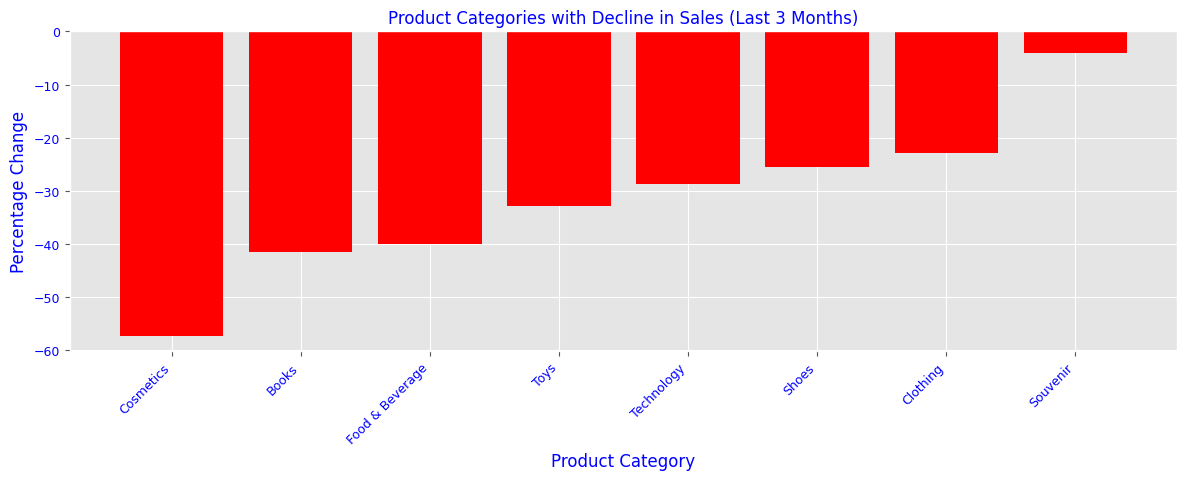

In [8]:
# Plot the percentage changes
plt.figure(figsize=(12, 5))
plt.bar(categories_with_decline_percentage['category'], categories_with_decline_percentage['percentage_change'], color='red')
plt.xlabel('Product Category', color='blue',fontsize=12)
plt.ylabel('Percentage Change',color='blue',fontsize=12)
plt.title('Product Categories with Decline in Sales (Last 3 Months)',color='blue',fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.tick_params(axis='x', which='both', labelsize=9, labelcolor='blue')
plt.tick_params(axis='y', which='both', labelsize=9, labelcolor='blue')
plt.show()

**Observation**:

- All product categories experienced decline in the last 3 months.


- Cosmetics category experienced the highest decline.

### 3. What is the average price of products in the electronics category?

In [9]:
# average price for electronics
average_price_toys = data[data['category'] == 'Toys']['price'].mean()

print(f"The average price of products in the toys category is: ${average_price_toys:,.2f}")


The average price of products in the toys category is: $107.73


### 4. What is the category with most expensive products?

In [10]:
# category average prices
category_average_prices = data.groupby('category')['price'].mean()

most_expensive_category = category_average_prices.idxmax()

most_expensive_average_price = category_average_prices.max()

print(f"The category with the most expensive products is: {most_expensive_category} \
- ${most_expensive_average_price:,.2f}")


The category with the most expensive products is: Technology - $3,156.94


### 5. How does the quantity sold in the clothing category compare to the shoes category?

In [11]:
# qunatity sold in each category
clothing_quantity = data[data['category'] == 'Clothing']['quantity'].sum()
shoes_quantity = data[data['category'] == 'Shoes']['quantity'].sum()

print(f"Quantity sold in the clothing category: {clothing_quantity:,}")
print(f"Quantity sold in the shoes category: {shoes_quantity:,}")

if clothing_quantity > shoes_quantity:
    print("Clothing category sold more.")
elif clothing_quantity < shoes_quantity:
    print("Shoes category sold more.")
else:
    print("Clothing and shoes categories sold the same quantity.")


Quantity sold in the clothing category: 103,558
Quantity sold in the shoes category: 30,217
Clothing category sold more.


### 6. Can you identify the top three products in each category based on sales?

In [12]:
# top products on sales
top_products_by_category = data.groupby('category')['total_revenue'].sum().reset_index()

top_products = top_products_by_category.nlargest(3, 'total_revenue')

top_products['total_revenue'] = top_products['total_revenue'].apply(format_revenue_with_thousand_separator)

print("Top three products in each category based on sales:\n")
print(top_products)

Top three products in each category based on sales:

     category    total_revenue
1    Clothing  $113,996,791.04
4       Shoes   $66,553,451.47
6  Technology   $57,862,350.00


### 7. Is there a noticeable seasonal pattern in the sales of each category in 2022?

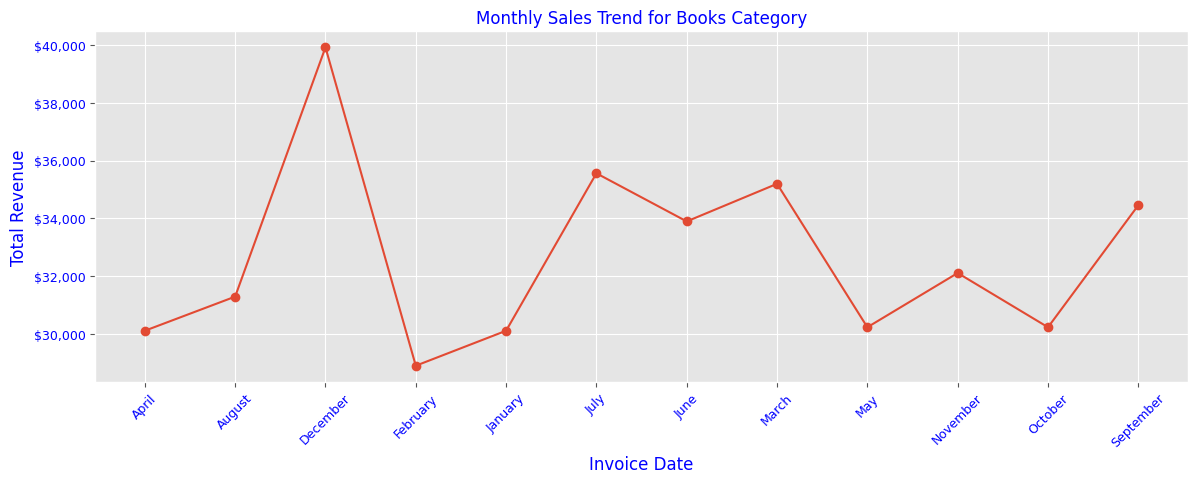

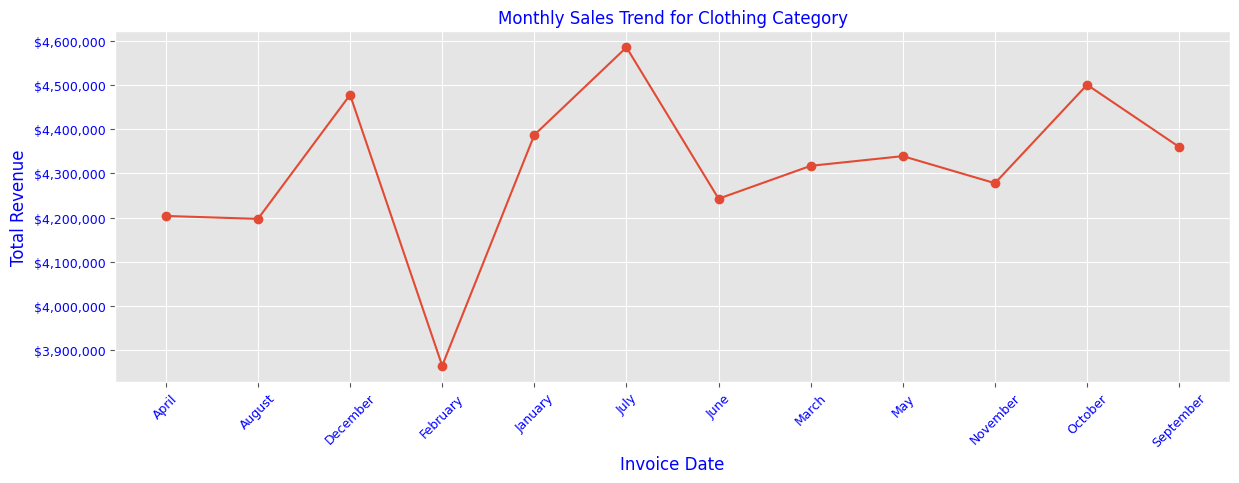

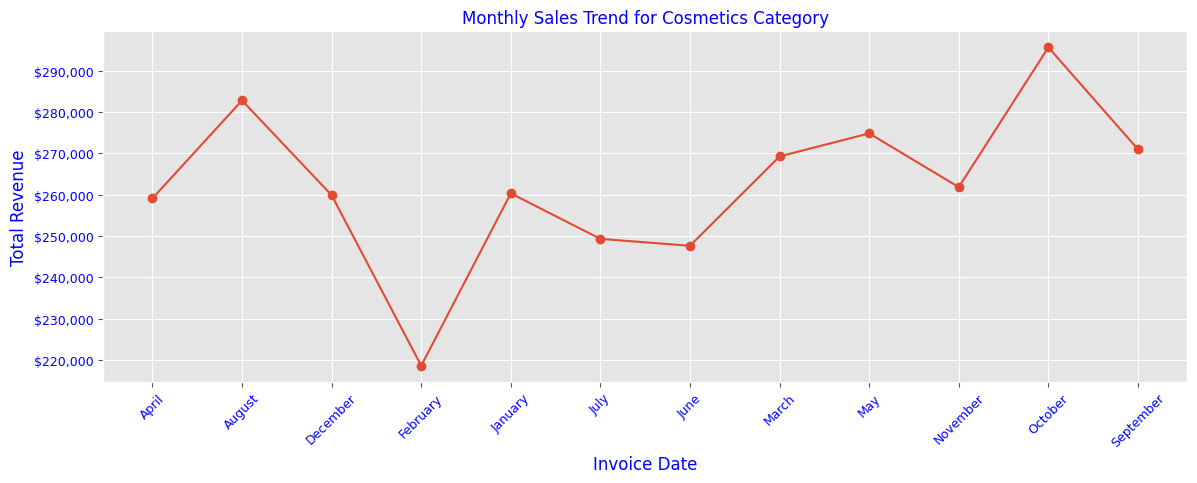

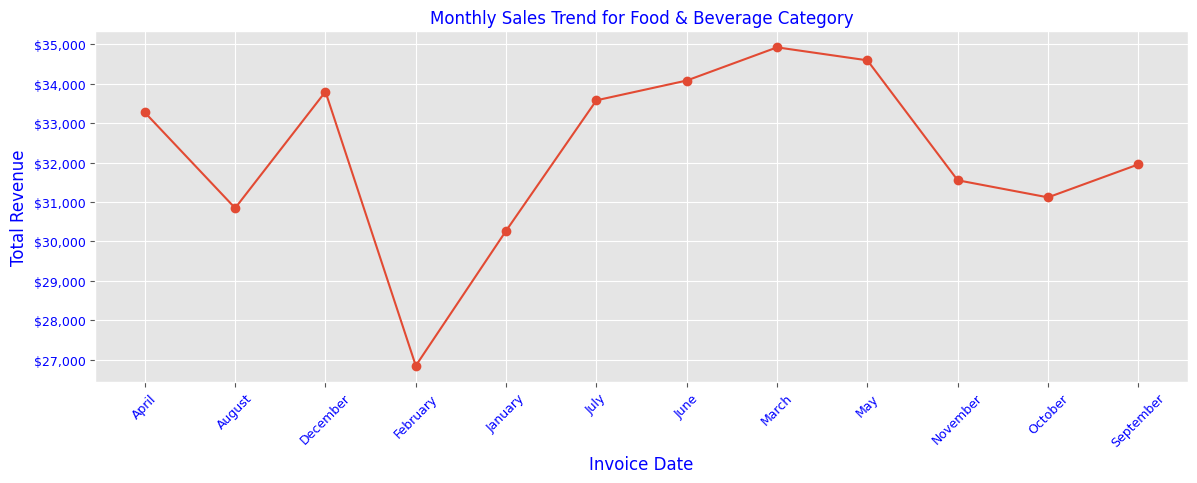

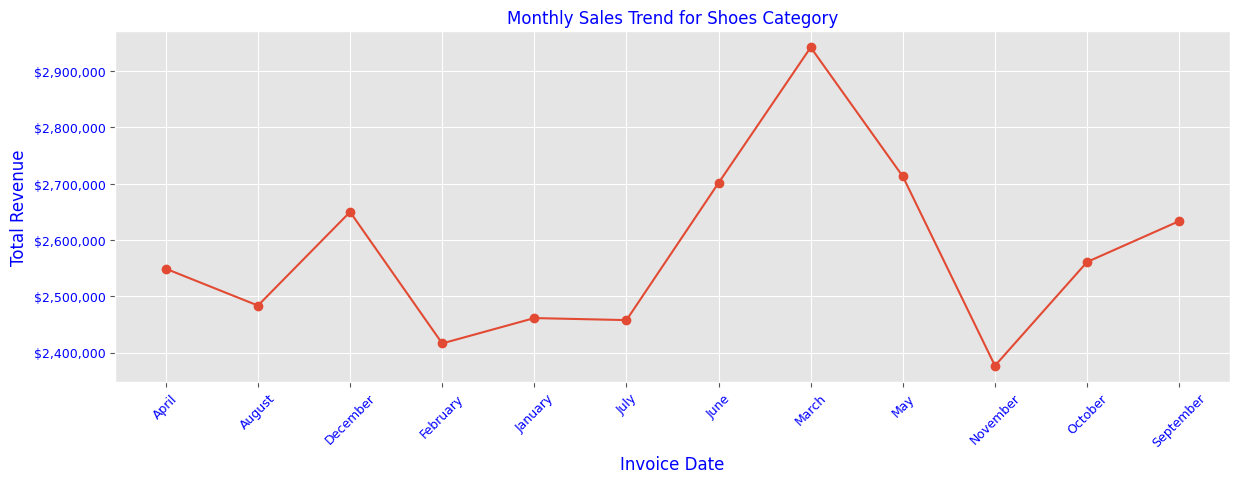

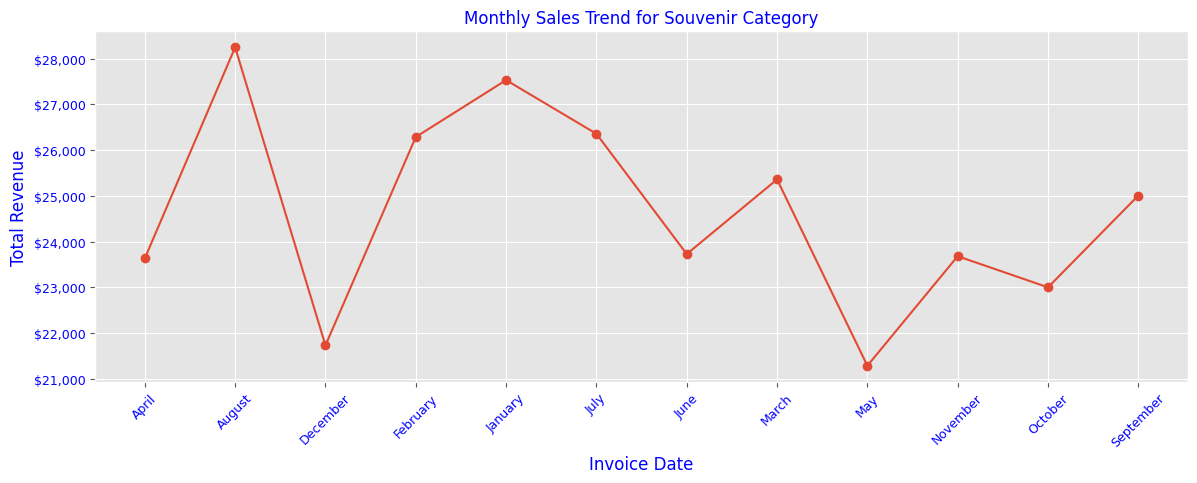

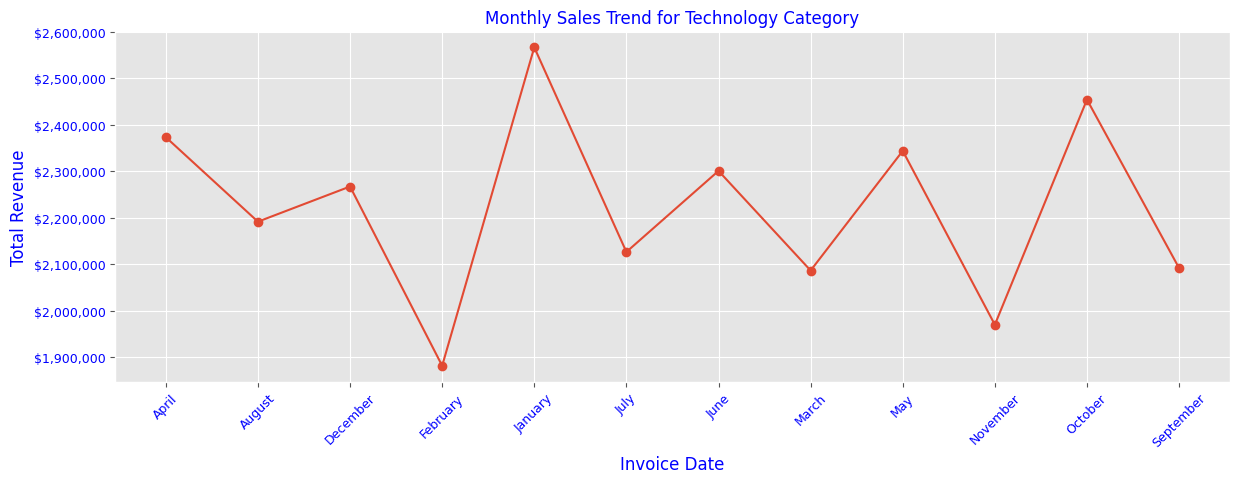

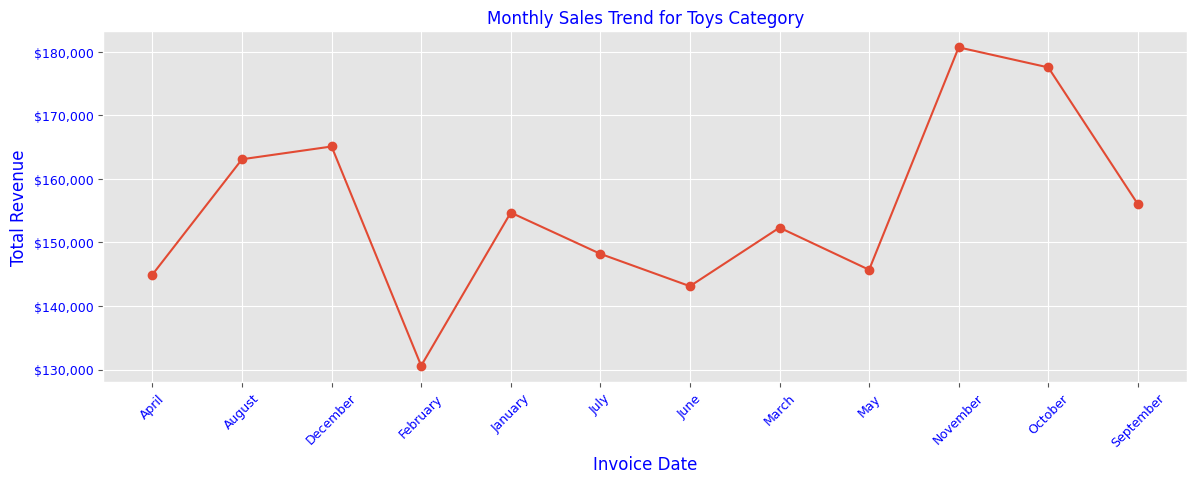

In [13]:
# sales in 2022 based on category
period_data = data[data['invoice_year']==2022]

category_monthly_sales = period_data.groupby(['category', 'invoice_year', 'invoice_month'])['total_revenue'].sum().reset_index()

# line plots for each category
categories = category_monthly_sales['category'].unique()

for category in categories:
    category_data = category_monthly_sales[category_monthly_sales['category'] == category]
    plt.figure(figsize=(12, 5))
    plt.plot(category_data['invoice_month'], category_data['total_revenue'], marker='o')
    plt.title(f"Monthly Sales Trend for {category} Category", color='blue',fontsize=12)
    plt.xlabel("Invoice Date",color='blue',fontsize=12)
    plt.ylabel("Total Revenue",color='blue',fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.gca().yaxis.set_major_formatter(mticker.StrMethodFormatter('${x:,.0f}'))
    plt.tick_params(axis='x', which='both', labelsize=9, labelcolor='blue')
    plt.tick_params(axis='y', which='both', labelsize=9, labelcolor='blue')
    plt.show()


**Observation**: No observable trend in any products

### 8. Can you identify any categories that customers tend to buy together frequently?

In [14]:
# Calculate the correlation matrix 
category_matrix = pd.get_dummies(data['category'])

correlation_matrix = np.corrcoef(category_matrix, rowvar=False)

category_correlation = pd.DataFrame(correlation_matrix, 
                            columns=category_matrix.columns, index=category_matrix.columns)
print("Category Co-occurrence Matrix:")
category_correlation


Category Co-occurrence Matrix:


,Books,Clothing,Cosmetics,Food & Beverage,Shoes,Souvenir,Technology,Toys
Books,1.00,-0.17,-0.10,-0.10,-0.08,-0.05,-0.05,-0.08
Clothing,-0.17,1.00,-0.31,-0.30,-0.24,-0.17,-0.17,-0.24
Cosmetics,-0.10,-0.31,1.00,-0.18,-0.14,-0.10,-0.10,-0.14
Food & Beverage,-0.10,-0.30,-0.18,1.00,-0.14,-0.10,-0.10,-0.14
Shoes,-0.08,-0.24,-0.14,-0.14,1.00,-0.08,-0.08,-0.11
Souvenir,-0.05,-0.17,-0.10,-0.10,-0.08,1.00,-0.05,-0.08
Technology,-0.05,-0.17,-0.10,-0.10,-0.08,-0.05,1.00,-0.08
Toys,-0.08,-0.24,-0.14,-0.14,-0.11,-0.08,-0.08,1.00


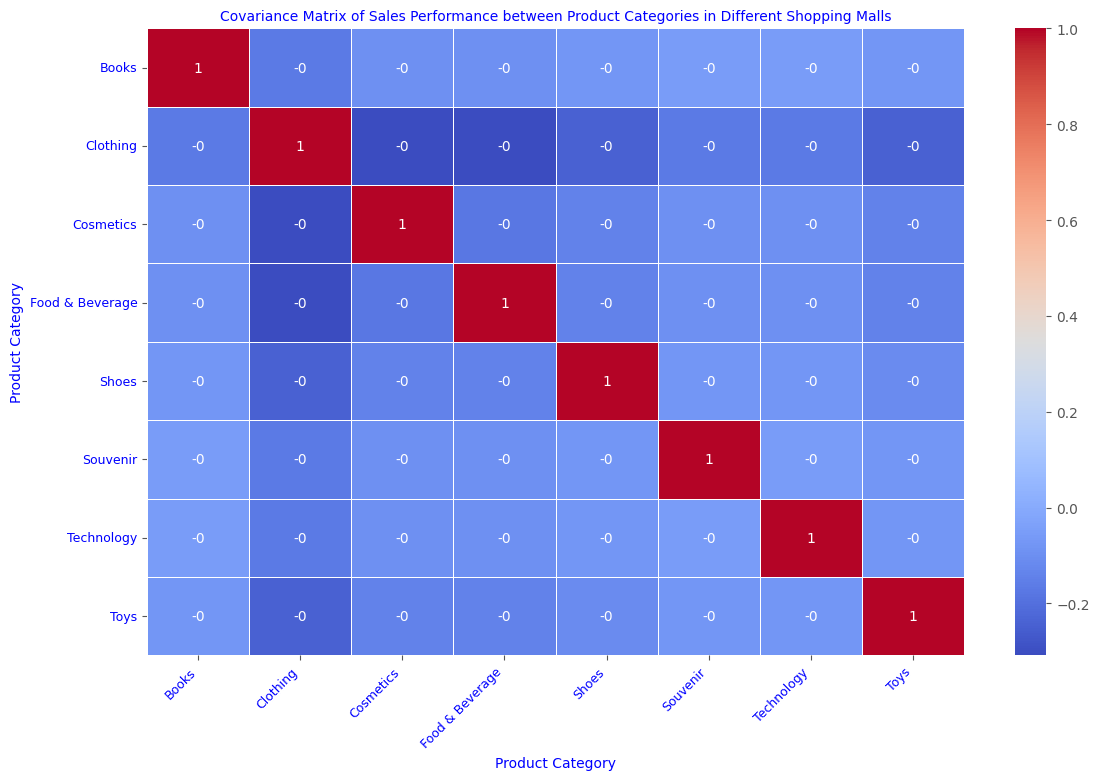

In [15]:
# plot the correlation matrix

plt.figure(figsize=(12, 8))
sns.heatmap(category_correlation, cmap='coolwarm', annot=True, fmt='.0f', linewidths=.5)

plt.title("Covariance Matrix of Sales Performance between Product Categories in Different Shopping Malls",
         color='blue', fontsize=10)
plt.xlabel("Product Category",color='blue', fontsize=10)
plt.ylabel("Product Category",color='blue', fontsize=10)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.tick_params(axis='x', which='both', labelsize=9, labelcolor='blue')
plt.tick_params(axis='y', which='both', labelsize=9, labelcolor='blue')
plt.show()

**Observation**: No products go together. This is because, based on the data, there are no products from different categories that have been bought togther.

### 9. Are there specific product categories that perform exceptionally well in certain shopping malls?

In [16]:
# total sales for each mall and category
mall_category_sales = data.groupby(['shopping_mall', 'category'])['total_revenue'].sum().reset_index()

# highest sales in each shopping mall
top_category_in_mall = mall_category_sales.groupby('shopping_mall')['total_revenue'].idxmax()
top_category_performance = mall_category_sales.loc[top_category_in_mall]

top_category_performance['total_revenue'] = \
        top_category_performance['total_revenue'].apply(format_revenue_with_thousand_separator)

print("Top-performing categories in each shopping mall:\n")
print(top_category_performance)


Top-performing categories in each shopping mall:

        shopping_mall  category   total_revenue
1         Cevahir AVM  Clothing   $5,706,321.28
9   Emaar Square Mall  Clothing   $5,590,490.40
17     Forum Istanbul  Clothing   $5,792,444.24
25       Istinye Park  Clothing  $11,253,900.24
33             Kanyon  Clothing  $22,609,527.60
41   Mall of Istanbul  Clothing  $22,947,417.68
49          Metrocity  Clothing  $17,226,692.56
57       Metropol AVM  Clothing  $11,568,084.00
65     Viaport Outlet  Clothing   $5,604,594.16
73       Zorlu Center  Clothing   $5,697,318.88


**Observation**: Clothing performs exceptionally well in all shopping malls